In [1]:
import CNN2Head_input2 as CNN2Head_input
import tensorflow as tf
import numpy as np
import BKNetStyle2 as BKNetStyle
from const import *

''' PREPARE DATA '''
smile_train, smile_test = CNN2Head_input.getSmileImage()
gender_train, gender_test = CNN2Head_input.getGenderImage()
age_train, age_test = CNN2Head_input.getAgeImage()
'''--------------------------------------------------------------------------------------------'''

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load smile image...................
Done !
Number of smile train data:  3000
---------------------------------------------------------------
Load gender image...................
Done !
Number of gender train data:  96000
---------------------------------------------------------------
Load age image...................
Done !
Number of age train data:  96000
---------------------------------------------------------------


'--------------------------------------------------------------------------------------------'

In [2]:
def one_hot(index, num_classes):
    assert index < num_classes and index >= 0
    tmp = np.zeros(num_classes, dtype=np.float32)
    tmp[index] = 1.0
    return tmp

In [3]:
sess = tf.InteractiveSession()
x, y_, mask = BKNetStyle.Input()

y_smile_conv, y_gender_conv, y_age_conv, phase_train, keep_prob = BKNetStyle.BKNetModel(x)

In [4]:
def my_confusion_matrix(y_true, y_pred):
    N = np.unique(y_true).shape[0] # number of classes 
    cm = np.zeros((N, N))
    for n in range(y_true.shape[0]):
        cm[y_true[n], y_pred[n]] += 1
    return cm 

In [5]:
smile_loss, gender_loss, age_loss, l2_loss, loss = BKNetStyle.selective_loss(y_smile_conv, y_gender_conv,
                                                                             y_age_conv, y_, mask)
smile_mask = tf.get_collection('smile_mask')[0]
gender_mask = tf.get_collection('gender_mask')[0]
age_mask = tf.get_collection('age_mask')[0]

y_smile = tf.get_collection('y_smile')[0]
y_gender = tf.get_collection('y_gender')[0]
y_age = tf.get_collection('y_age')[0]

smile_correct_prediction = tf.equal(tf.argmax(y_smile_conv, 1), tf.argmax(y_smile, 1))
gender_correct_prediction = tf.equal(tf.argmax(y_gender_conv, 1), tf.argmax(y_gender, 1))
# age_correct_prediction = tf.equal(tf.argmax(y_age_conv, 1), tf.argmax(y_age, 1))

smile_true_pred = tf.reduce_sum(tf.cast(smile_correct_prediction, dtype=tf.float32) * smile_mask)
gender_true_pred = tf.reduce_sum(tf.cast(gender_correct_prediction, dtype=tf.float32) * gender_mask)
age_mae, update_op = tf.metrics.mean_absolute_error(
    tf.argmax(y_age, 1), tf.argmax(y_age_conv, 1), name="age_mae")
running_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="age_mae")
running_vars_initializer = tf.variables_initializer(var_list=running_vars)
sess.run(running_vars_initializer)

test_data = []

# Mask: Smile -> 0, Gender -> 1, Age -> 2
for i in range(len(smile_test)):
    img = (smile_test[i % 3000][0] - 128) / 255.0
    label = smile_test[i % 3000][1]
    test_data.append((img, one_hot(label, 101), 0.0))
for i in range(len(gender_test)):
    img = (gender_test[i][0] - 128) / 255.0
    label = (int)(gender_test[i][1])
    test_data.append((img, one_hot(label, 101), 1.0))
for i in range(len(age_test)):
    img = (age_test[i][0] - 128) / 255.0
    label = (int)(age_test[i][1])
    test_data.append((img, one_hot(label, 101), 2.0))
np.random.shuffle(test_data)

print('Restore model')
saver = tf.train.Saver()
saver.restore(sess, SAVE_FOLDER2 + 'model-age101.ckpt')
print('OK')

train_img = []
train_label = []
train_mask = []

for i in range(len(test_data)):
    train_img.append(test_data[i][0])
    train_label.append(test_data[i][1])
    train_mask.append(test_data[i][2])

number_batch = len(test_data) // BATCH_SIZE

smile_nb_true_pred = 0
gender_nb_true_pred = 0

smile_nb_train = 0
gender_nb_train = 0
age_nb_train = 0

y_smile_pred = np.array([])
y_smile_true = np.array([])
y_gender_pred = np.array([])
y_gender_true = np.array([])
y_age_pred = np.array([])
y_age_true = np.array([])

for batch in range(number_batch):

    top = batch * BATCH_SIZE
    bot = min((batch + 1) * BATCH_SIZE, len(test_data))
    batch_img = np.asarray(train_img[top:bot])
    batch_label = np.asarray(train_label[top:bot])
    batch_mask = np.asarray(train_mask[top:bot])

    # batch_img = CNN2Head_input.random_crop(batch_img, (48, 48), 10)

    for i in range(BATCH_SIZE):
        if batch_mask[i] == 0.0:
            smile_nb_train += 1
        else:
            if batch_mask[i] == 1.0:
                gender_nb_train += 1
            else:
                age_nb_train += 1

    smile_nb_true_pred += sess.run(smile_true_pred, feed_dict={x: batch_img, y_: batch_label, mask: batch_mask,
                                                               phase_train: False,
                                                               keep_prob: 1})

    gender_nb_true_pred += sess.run(gender_true_pred,
                                    feed_dict={x: batch_img, y_: batch_label, mask: batch_mask,
                                               phase_train: False,
                                               keep_prob: 1})

    sess.run(update_op,
            feed_dict={x: batch_img, y_: batch_label, mask: batch_mask,
                       phase_train: False,
                       keep_prob: 1})
    
    batch_smile_true, batch_smile_pred = sess.run([tf.argmax(y_smile, 1), tf.argmax(y_smile_conv, 1)],
            feed_dict={x: batch_img, y_: batch_label, mask: batch_mask,
                       phase_train: False,
                       keep_prob: 1})
    
    batch_gender_true, batch_gender_pred = sess.run([tf.argmax(y_gender, 1), tf.argmax(y_gender_conv, 1)],
            feed_dict={x: batch_img, y_: batch_label, mask: batch_mask,
                       phase_train: False,
                       keep_prob: 1})
    
    batch_age_true, batch_age_pred = sess.run([tf.argmax(y_age, 1), tf.argmax(y_age_conv, 1)],
            feed_dict={x: batch_img, y_: batch_label, mask: batch_mask,
                       phase_train: False,
                       keep_prob: 1})
       
    y_smile_true = np.append(y_smile_true, batch_smile_true)
    y_smile_pred = np.append(y_smile_pred, batch_smile_pred)
    y_gender_true = np.append(y_gender_true, batch_gender_true)
    y_gender_pred = np.append(y_gender_pred, batch_gender_pred)
    y_age_true = np.append(y_age_true, batch_age_true)
    y_age_pred = np.append(y_age_pred, batch_age_pred)    

smile_train_accuracy = smile_nb_true_pred * 1.0 / smile_nb_train
gender_train_accuracy = gender_nb_true_pred * 1.0 / gender_nb_train
age_train_error = sess.run(age_mae)

print('\n')
print('Smile task train accuracy: ' + str(smile_train_accuracy * 100))
print('Gender task train accuracy: ' + str(gender_train_accuracy * 100))
print('Age task train error: ' + str(age_train_error))

Restore model
INFO:tensorflow:Restoring parameters from ./save/current2/model-age101.ckpt
OK


Smile task train accuracy: 90.82568807339449
Gender task train accuracy: 90.75769439257965
Age task train error: 21.2893


In [6]:
y_smile_true

array([1., 1., 0., ..., 1., 0., 1.])

In [7]:
y_smile_pred_2 = y_smile_pred.astype(int)
y_smile_true_2 = y_smile_true.astype(int)
y_gender_pred_2 = y_gender_pred.astype(int)
y_gender_true_2 = y_gender_true.astype(int)
y_age_pred_2 = y_age_pred.astype(int)
y_age_true_2 = y_age_true.astype(int)

In [8]:
print(len(y_smile_pred))
print(len(y_smile_true))
print(len(y_gender_pred))
print(len(y_gender_true))
print(len(y_age_pred))
print(len(y_age_true))

67072
67072
67072
67072
67072
67072


In [9]:
np.unique(y_age_true).astype(int)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96])

In [10]:
from sklearn.metrics import confusion_matrix

In [34]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix:
[[27311 21625]
 [ 6296 11840]]


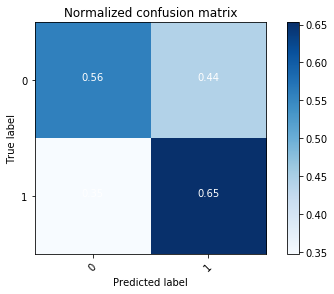

In [39]:
cnf_matrix = confusion_matrix(y_smile_true_2, y_smile_pred_2)
print('Confusion matrix:')
print(cnf_matrix)

# Plot non-normalized confusion matrix
class_names = np.unique(y_smile_true).astype(int)
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix:
[[29317 19619]
 [ 1745 16391]]


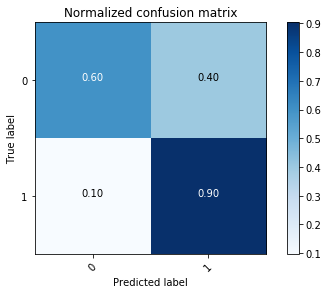

In [36]:
cnf_matrix = confusion_matrix(y_gender_true_2, y_gender_pred_2)
print('Confusion matrix:')
print(cnf_matrix)

# Plot non-normalized confusion matrix
class_names = np.unique(y_smile_true).astype(int)
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


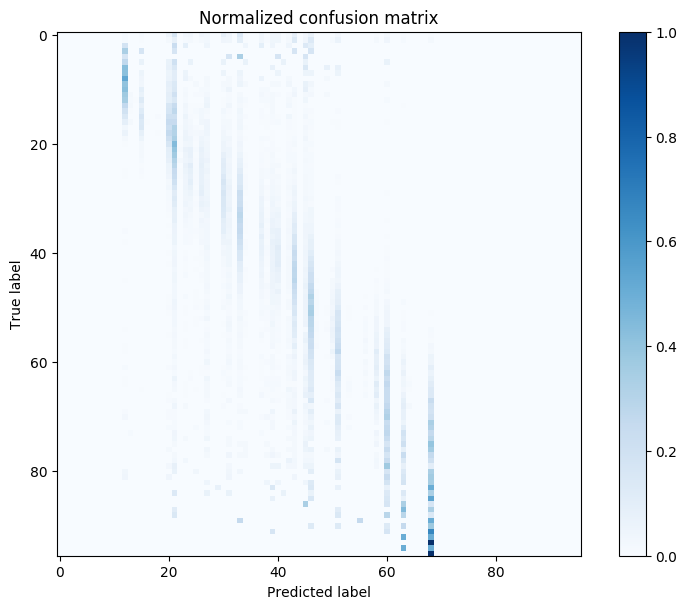

In [16]:
cnf_matrix = confusion_matrix(y_age_true_2, y_age_pred_2)
print('Confusion matrix:')
print(cnf_matrix)

# Plot non-normalized confusion matrix
class_names = np.unique(y_age_true).astype(int)
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()